In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

from scipy.integrate import odeint

from RungeKutta_Parallel import *

import dask.dataframe as dd
from dask import delayed
from dask import compute


In [8]:
dir    = "DATA/"
file1  = 'BHBH.csv'
file2  = 'BHBHm.csv'

BHBHm  = pd.read_csv(dir+file2)
BHBHm  = BHBHm.head(8)
BHBHm  = dd.from_pandas(BHBHm, npartitions=8)

#BHBHm  = BHBHm.head(10, compute=False)

TMIN   = 0;  TMAX = 13 # s
NSTEPS = int(1e4)
h = ( TMAX - TMIN ) / (NSTEPS - 1.)

In [3]:
h = ( TMAX - TMIN ) / (NSTEPS - 1.)
t = np.linspace(TMIN, TMAX, NSTEPS)

# delay = np.zeros(shape=len(BHBHm.index))

def delay_time(row, h, t):
    M1 = row.Mass_0
    M2 = row.Mass_1

    a, e = (np.empty(shape=NSTEPS, dtype=object) for i in range(N))
    a[0] = row.Semimajor
    e[0] = row.Eccentricity

    for i in range(NSTEPS-1):
        ae   = compute(ODE_RK( t[i], [a[i], e[i]], h, M2, M1 ))
        a[i+1], e[i+1] = ae[0]

    return a, e

delay = BHBHm.map_partitions(func=delay_time, h=h, t=t, meta=('delay', 'f8'))


In [4]:
delay.compute()

KeyboardInterrupt: 

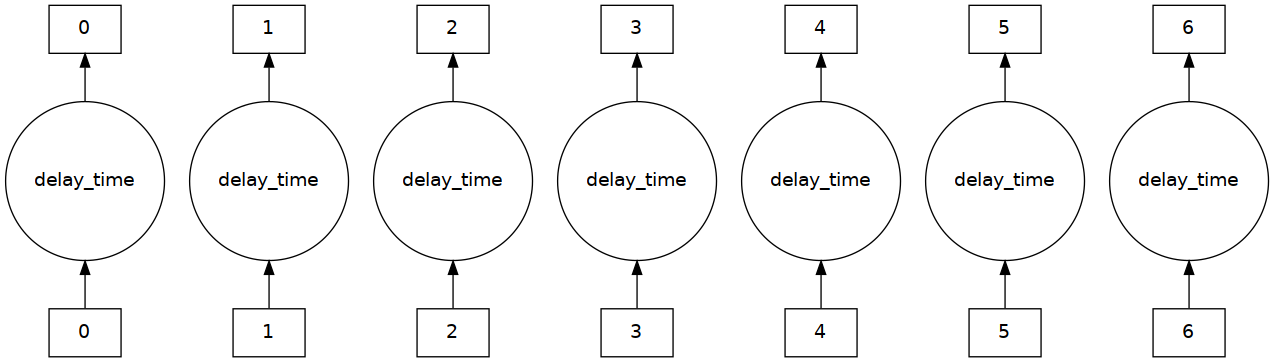

In [5]:
delay.visualize()

In [6]:
import RungeKutta

def system_ODE(curr_state, t, M, m):
    return RungeKutta.deriv( t, curr_state, M, m )

def delay_time_SP(row, h, t):
    M1 = row.Mass_0
    M2 = row.Mass_1

    initial_state = (row.Semimajor, row.Eccentricity)

    return odeint(system_ODE, initial_state, t, args=(M2, M1))

delay = BHBHm.map_partitions(func=delay_time_SP, h=h, t=t, meta=('delay', 'f8'))
delay.compute()

ValueError: Initial condition y0 must be one-dimensional.

In [9]:
BHBHm

,ID,name,BWorldtime,Mass_0,Radius_0,Zams_0,Phase_0,RemnantType_0,Mass_1,Radius_1,Phase_1,Zams_1,RemnantType_1,Semimajor,Eccentricity,GWtime,EventsAll,Events,EventsPlus,Mzams_0,Mzams_1,Semimajor_ini,Eccentricity_ini,Z,alpha
npartitions=7,,,,,,,,,,,,,,,,,,,,,,,,,
0,int64,object,float64,float64,float64,float64,int64,int64,float64,float64,int64,float64,int64,float64,float64,float64,object,object,object,float64,float64,float64,float64,float64,float64
1,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
"""h = ( TMAX - TMIN ) / (NSTEPS - 1.)
t = np.linspace(TMIN, TMAX, NSTEPS)

# delay = np.zeros(shape=len(BHBHm.index))

def delay_time(row, h, t_min):
    M1 = row.Mass_0
    M2 = row.Mass_1

    #a, e = (np.zeros(shape=NSTEPS) for i in range(N))
    a = row.Semimajor
    e = row.Eccentricity

    t = t_min

    while a > 0 or e > 0:
        ae   = compute(ODE_RK( t, [a, e], h, M2, M1 ))
        a, e = ae[0]
        t += h

    return t

def delay_time_partition(df, h, t_min):
    return df.apply(func=delay_time, axis='columns', args=(h, t_min))

delay = BHBHm.map_partitions(func=delay_time_partition, h=h, t_min=TMIN, meta=('delay', 'f8'))"""

In [ ]:
"""h = ( TMAX - TMIN ) / (NSTEPS - 1.)

def delay_time(row, h, t_min):
    M1 = row.Mass_0
    M2 = row.Mass_1

    #a, e = (np.zeros(shape=NSTEPS) for i in range(N))
    a = row.Semimajor
    e = row.Eccentricity

    t = t_min

    while a > 0 or e > 0:
        ae   = compute(ODE_RK( t, [a, e], h, M2, M1 ))
        a, e = ae[0]
        t += h

    return t

delay = BHBHm.map_partitions(func=delay_time, h=h, t_min=TMIN, meta=('delay', 'f8'))
"""

In [ ]:
"""M1, M2 = (BHBHm['Mass_0'], BHBHm['Mass_1'])
a0, e0 = (BHBHm['Semimajor'], BHBHm['Eccentricity'])

delays = np.zeros(shape=len(BHBHm.index))

for i, (M, m, a_, e_) in enumerate(zip(M1, M2, a0, e0)):
    t = TMIN

    a, e = (a_, e_)

    while a > 0 or e > 0:
        ae   = compute(ODE_RK( t, [a, e], h, M2, M1 ))
        a, e = ae[0]
        t += h

    delays[i] = t"""